# **Creación de data tabular de la señales fisiológicas obtenidas en los laboratorios**

In [4]:
#Importación de librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import biosignalsnotebooks as bsnb
from scipy.signal import iirnotch
from scipy.signal import lfilter
import scipy

In [5]:
#Seleccionamos estilo de ploteo
plt.style.use("ggplot")


## Lectura de los datos

In [6]:
#Lectura de documento txt con tabulación (/t) como delimitador
array1 = np.genfromtxt("ECG_respiracion10.txt", delimiter="\t")
array1

array([[  0.,   0.,   0., ...,   0., 553.,  nan],
       [  1.,   0.,   0., ...,   0., 537.,  nan],
       [  2.,   0.,   0., ...,   0., 520.,  nan],
       ...,
       [  7.,   0.,   0., ...,   0., 522.,  nan],
       [  8.,   0.,   0., ...,   0., 518.,  nan],
       [  9.,   0.,   0., ...,   0., 520.,  nan]])

In [7]:
#Nos quedamos con el dato del sensor
d_sensor = array1[:,-2]
d_sensor

array([553., 537., 520., ..., 522., 518., 520.])

# Definiendo Parámetros de la Señal Adquirida

In [8]:
resolution=10
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,d_sensor.shape[0])  # t = n*Ts
t = n*Ts

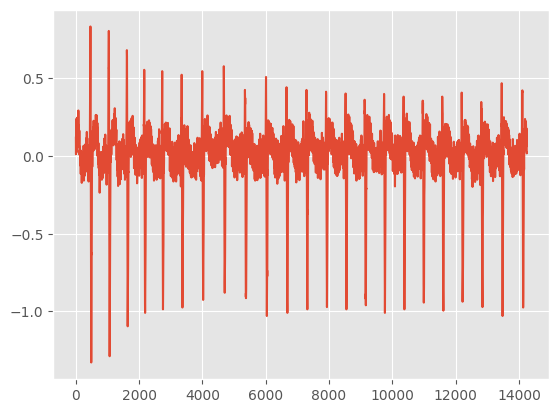

In [9]:
# Let's convert the signal's units, since we know it is a ECG signal
signal = bsnb.raw_to_phy("ECG", "biosignalsplux", d_sensor, resolution, "mV")
plt.plot(signal)


## Graficación de los datos

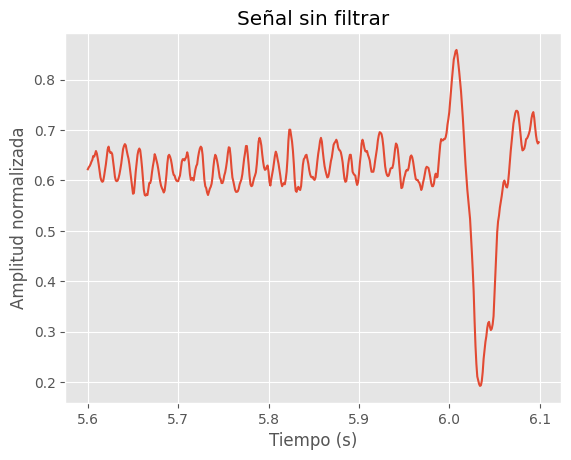

In [10]:
#plt.plot(t[0:500],d_sensor[0:500])
#plt.xlim(0,500)

senal_sin_filtrar_norm = d_sensor / max(abs(d_sensor)) #Se normalizan los valores
plt.plot(t[5600:6100],senal_sin_filtrar_norm[5600:6100], label='Señal sin filtrar')
plt.title("Señal sin filtrar")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("señal_sin_filtrar.png")

# TRANSFORMADA DE FOURIER (Análisis Frecuencial)

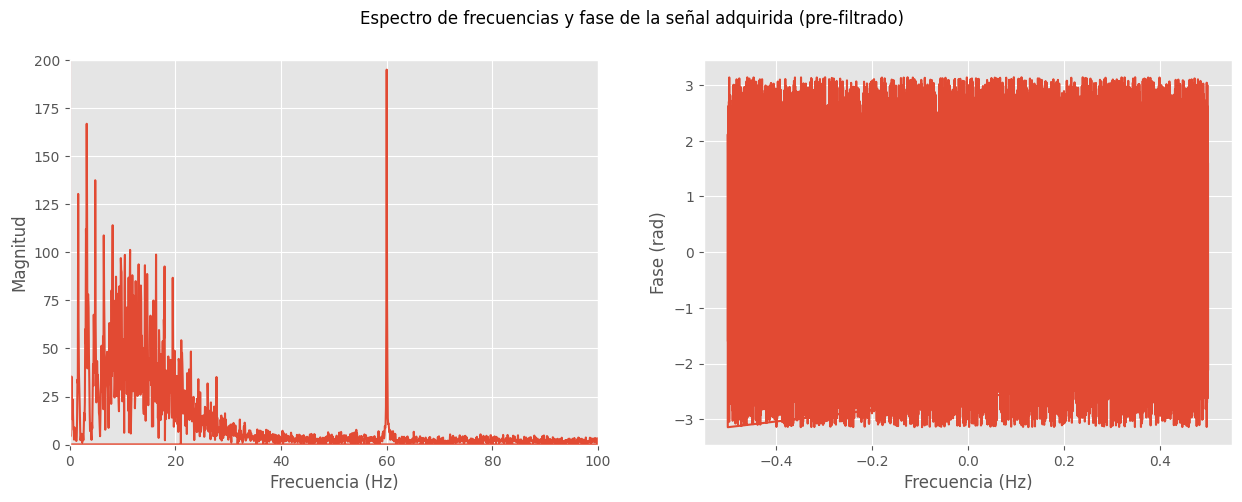

In [11]:
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin_filtrar_norm)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin_filtrar_norm))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (pre-filtrado)")

plt.savefig("espectro_before_filtering.png")

plt.show()

# Filtro Notch (Rechaza 60 Hz)

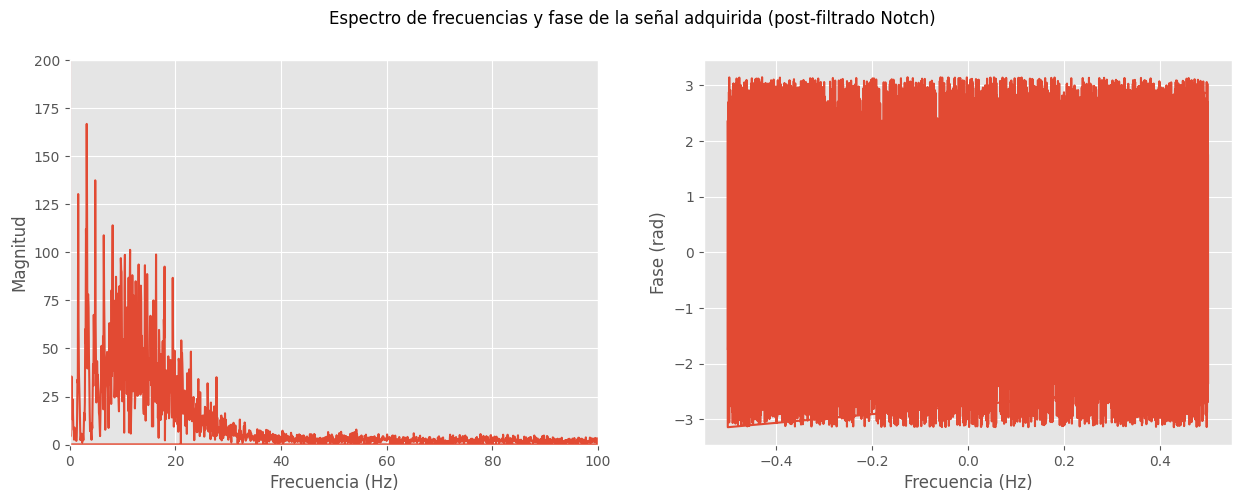

In [12]:
# Crear un filtro notch centrado en 60 Hz
f0 = 60.0  # frecuencia a eliminar
Q = 20.0  # factor de calidad
w0 = f0 / (Fs / 2)
b, a = iirnotch(w0, Q)

# Aplicar el filtro notch a la señal
senal_sin60Hz = scipy.signal.lfilter(b, a, senal_sin_filtrar_norm)

# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin60Hz)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin60Hz))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (post-filtrado Notch)")

plt.savefig("filtrado_notch.png")

plt.show()

#senal_sin60Hz=senal_sin_filtrar_norm // usar para eliminar el filtrado notch y ver el efecto sin este filtro

# Creando los Filtros (a partir de la libreria Bitalino)

In [13]:

# Creating a Butterworth filter with order 3 and low-pass frequency of 100 Hz
lfilter_signal = bsnb.lowpass(senal_sin60Hz, 100, order=3)
filtfilt_signal = bsnb.lowpass(senal_sin60Hz, 100, order=3, use_filtfilt=True)


# Filtrado Normal con Pasabajas

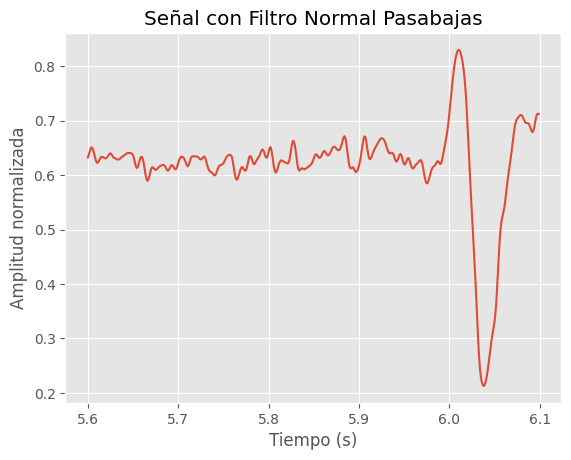

In [14]:

lfilter_signal = lfilter_signal / max(abs(lfilter_signal))
plt.plot(t[5600:6100],lfilter_signal[5600:6100])
plt.title("Señal con Filtro Normal Pasabajas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("filtrado_normal.png")

# Filtrado "filtfilt"

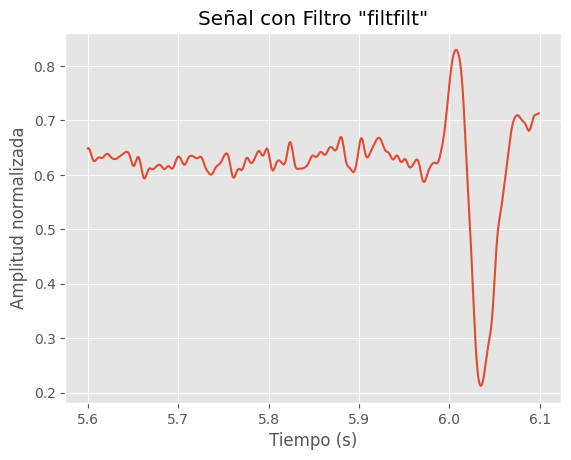

In [15]:

filtfilt_signal = filtfilt_signal / max(abs(filtfilt_signal))
plt.plot(t[5600:6100],filtfilt_signal[5600:6100])
plt.title('Señal con Filtro "filtfilt"')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

plt.savefig("filtrado_filtfilt.png")


# Comprobando la Efectividad de los Filtros

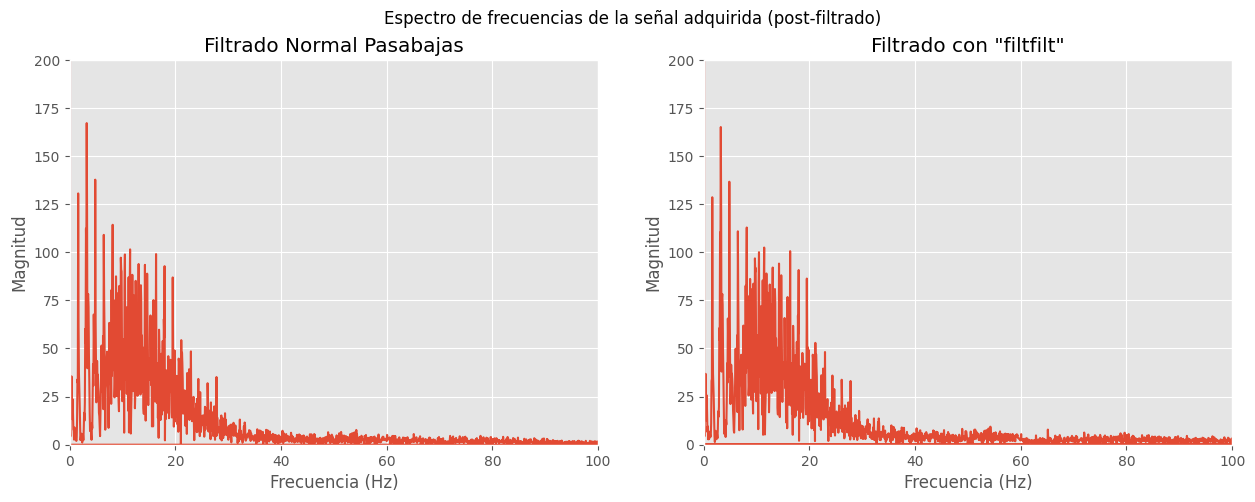

In [16]:
# Transformadas de Fourier
fft_signal_1 = np.fft.fft(filtfilt_signal)
fft_signal_2 = np.fft.fft(lfilter_signal)

# Magnitud de la transformada de Fourier
mag_signal_1 = np.abs(fft_signal_1)
mag_signal_2 = np.abs(fft_signal_2)

# Frecuencias
freqs_1 = np.fft.fftfreq(len(filtfilt_signal))
freqs_2 = np.fft.fftfreq(len(lfilter_signal))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Configurar títulos de subplots
axs[0].set_title('Filtrado Normal Pasabajas')
axs[1].set_title('Filtrado con "filtfilt"')

axs[0].plot(freqs_1*1000, mag_signal_1)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 200])
axs[0].set_xlim([0, 100])

axs[1].plot(freqs_2*1000, mag_signal_2)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Magnitud')
axs[1].set_ylim([0, 200])
axs[1].set_xlim([0, 100])

fig.suptitle("Espectro de frecuencias de la señal adquirida (post-filtrado)")

plt.savefig("espectro_after_filtering.png")

plt.show()

# PLOTEANDO SEÑALES (Sin filtro / Con filtro 1 / Con filtro 2)

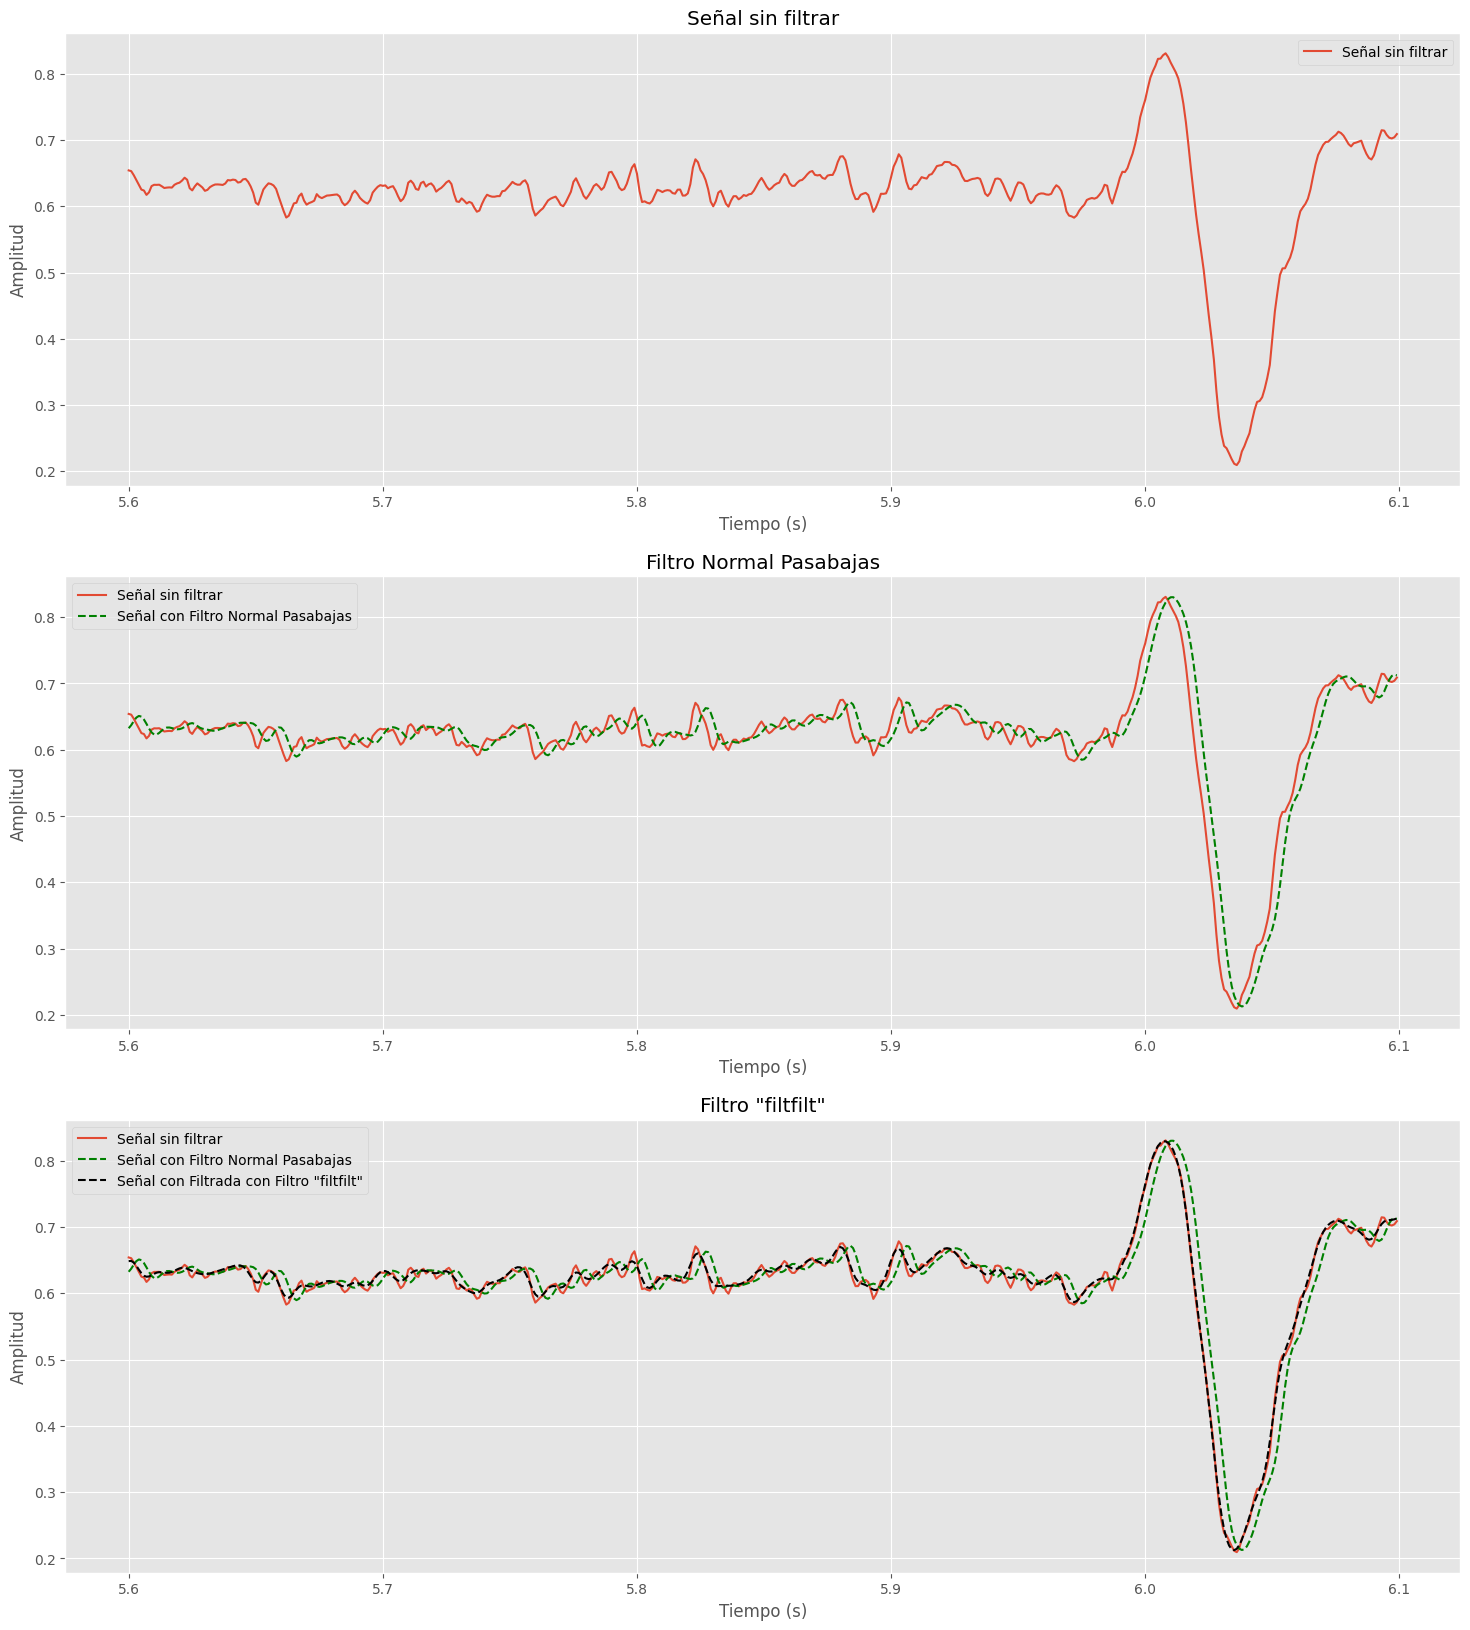

In [17]:
# Límites para mostrar
m=5600; #límite inferior
n=6100; #límite superior

# Le damos nuevas variables para el procesamiento
senal_filtro1_corr = lfilter_signal
senal_filtro2_corr = filtfilt_signal

# Crear figura y subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 20))

# Configurar títulos de subplots
axs[0].set_title('Señal sin filtrar')
axs[1].set_title('Filtro Normal Pasabajas')
axs[2].set_title('Filtro "filtfilt"')

# Graficar señal sin filtrar
axs[0].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Amplitud')
axs[0].legend()

# Graficar filtro 1
axs[1].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[1].plot(t[m:n], senal_filtro1_corr[m:n], label='Señal con Filtro Normal Pasabajas',linestyle='--', color="green")
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Amplitud')
axs[1].legend()

# Graficar filtro 2
axs[2].plot(t[m:n], senal_sin60Hz[m:n], label='Señal sin filtrar')
axs[2].plot(t[m:n], senal_filtro1_corr[m:n], label='Señal con Filtro Normal Pasabajas',linestyle='--', color="green")
axs[2].plot(t[m:n], senal_filtro2_corr[m:n], label='Señal con Filtrada con Filtro "filtfilt"',linestyle='--', color="black")
axs[2].set_xlabel('Tiempo (s)')
axs[2].set_ylabel('Amplitud')
axs[2].legend()

plt.savefig("comparativa_3x1.png")

# Mostrar plot
plt.show()

## Especificar la Frecuencia de muestreo 

In [18]:
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,d_sensor.shape[0])  # t = n*Ts
t = n*Ts

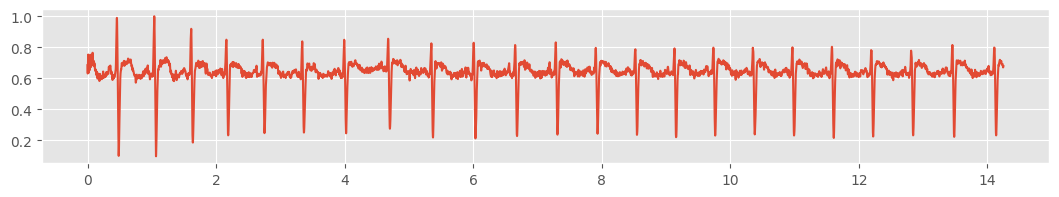

In [19]:
#Ploteamos la señal en el tiempo
plt.figure(figsize=(13,2)) #Modificamos el tamaño de la gráfica
plt.plot(t, senal_filtro2_corr)

## Pasando el array a pandas para trabajarlo como series de tiempo

In [20]:
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor = np.concatenate((t.reshape(-1,1),  senal_filtro2_corr.reshape(-1,1)), axis=1)

In [21]:
#Creamos el data frame con las varibles t y d_sensor
df = pd.DataFrame(st_sensor, columns=["t","senal_filtro2_corr"])
df.head()

,t,senal_filtro2_corr
0,0.000,0.684697
1,0.001,0.659653
2,0.002,0.640304
3,0.003,0.630959
4,0.004,0.633427


In [22]:
#Establecemos t como index 
df = df.set_index("t")
df.head()

,senal_filtro2_corr
t,
0.000,0.684697
0.001,0.659653
0.002,0.640304
0.003,0.630959
0.004,0.633427


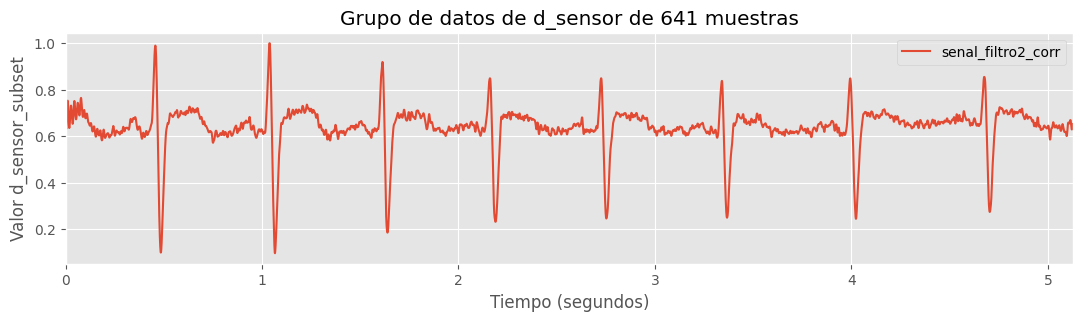

In [23]:
#Ploteamos la señal

df.plot(figsize=(13,3))
plt.xlim(0,5.128)
#####plt.plot(df.index, df.loc[936])#######
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor de 641 muestras")  # Cambiar el título
plt.show()


## Pasando a data tabular estilo Sklearn

In [24]:
df.index.max()/0.64

22.2640625

In [25]:
df.shape[0]/22

647.7272727272727

In [26]:
d_obs = df["senal_filtro2_corr"].values[:5128].reshape(8, 641)
d_obs

array([[0.68469672, 0.65965255, 0.64030364, ..., 0.70523581, 0.70260626,
        0.70160644],
       [0.70239868, 0.70482148, 0.70841502, ..., 0.68896381, 0.69308945,
        0.69507245],
       [0.69385707, 0.689261  , 0.68193726, ..., 0.62370499, 0.62136328,
        0.6180981 ],
       ...,
       [0.641391  , 0.64296458, 0.64371203, ..., 0.66036124, 0.66105365,
        0.66075098],
       [0.65916864, 0.65622499, 0.65219953, ..., 0.6714916 , 0.6743679 ,
        0.67635035],
       [0.6769144 , 0.67574493, 0.67291698, ..., 0.64347874, 0.64949236,
        0.65322142]])

<Figure size 1300x200 with 0 Axes>

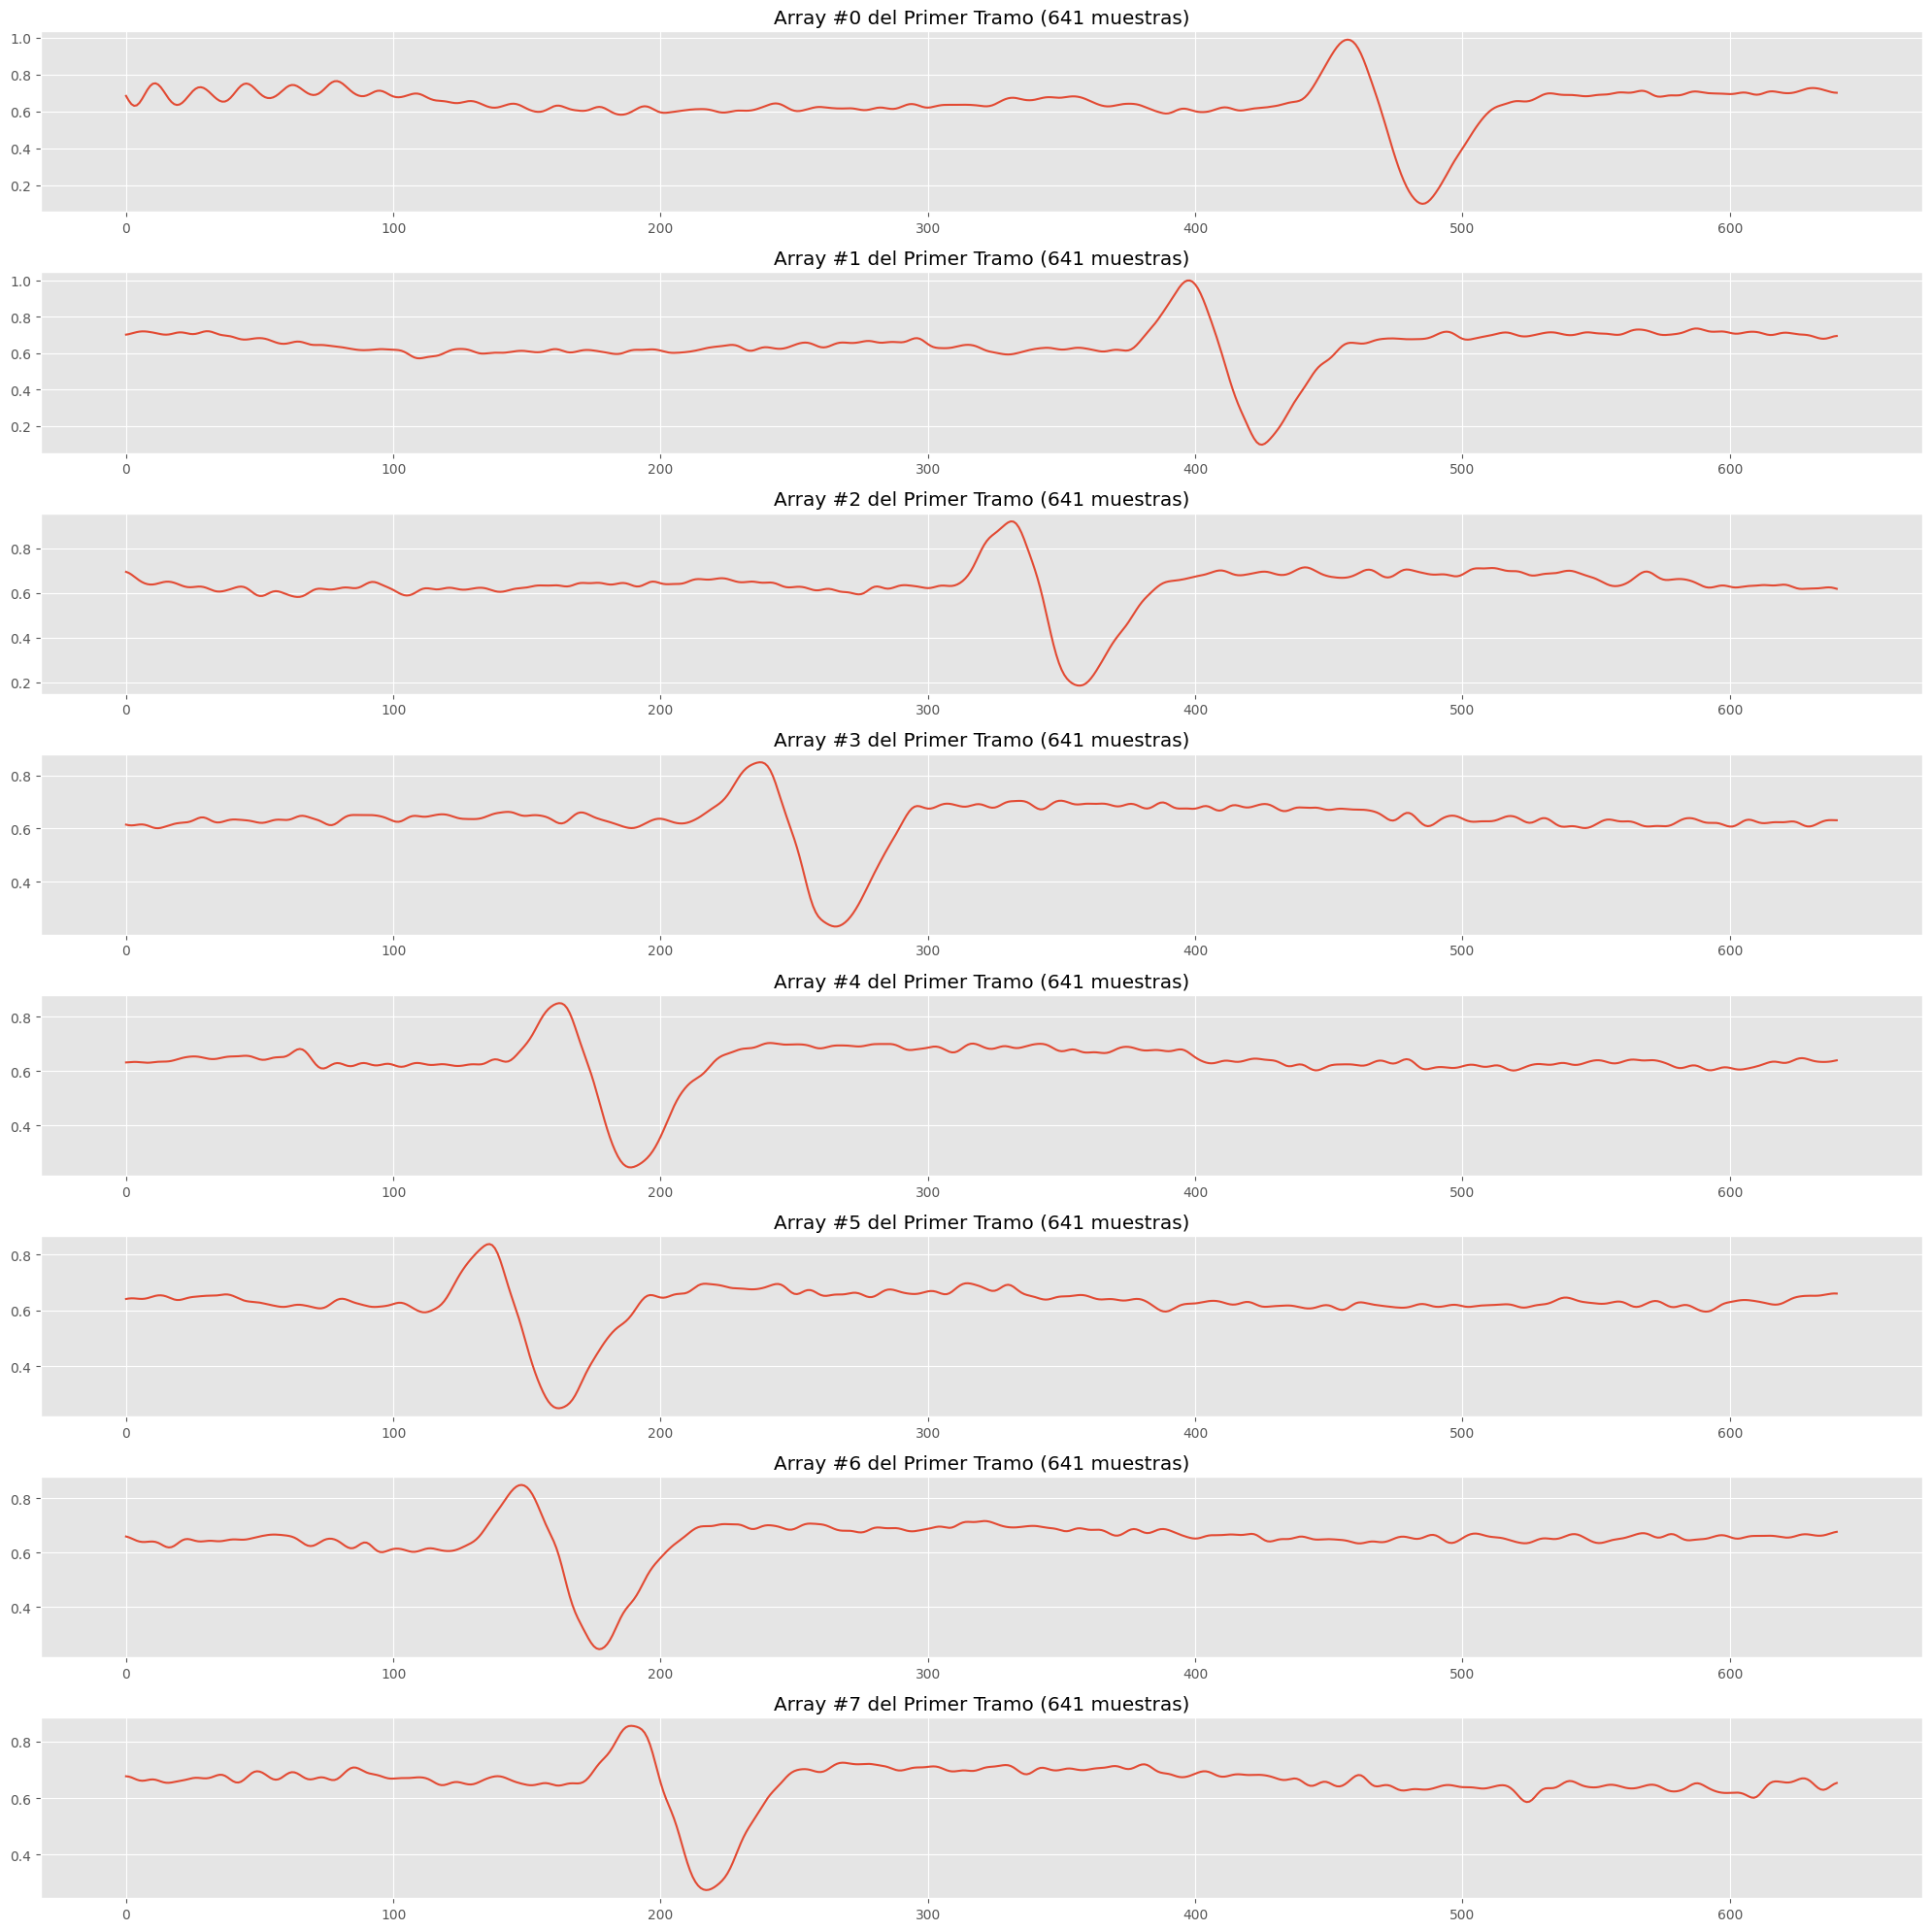

In [27]:
#plt.figure(figsize=(15,2))
#plt.plot(d_obs[7])
plt.figure(figsize=(13,2))
#plt.plot(d_obs[])

fig, axs = plt.subplots(nrows=8, figsize=(20, 20))

for i in range(8):
    axs[i].plot(d_obs[i])
    axs[i].set_title(f"Array #{i} del Primer Tramo (641 muestras)")
    
plt.tight_layout()
plt.show()

In [28]:
################ SEGUNDO GRUPO
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,5400)  # t = n*Ts
t_2 = n*Ts
len(t_2)
t_2

# Seleccionar valores desde el índice 4487 hasta el final de la columna "d_sensor"
d_sensor_subset = df["senal_filtro2_corr"].values[5128:10528]
len(d_sensor_subset)
d_sensor_subset


array([0.65380706, 0.65137808, 0.64695721, ..., 0.65556249, 0.6558671 ,
       0.65910769])

In [29]:
################ TERCER GRUPO
n = np.arange(0,3400)  # t = n*Ts
t_3 = n*Ts
len(t_3)
t_3

# Seleccionar valores desde el índice 4487 hasta el final de la columna "d_sensor"
d_sensor_subset_2 = df["senal_filtro2_corr"].values[10528:13928] #5 de 650=3250
len(d_sensor_subset_2)
d_sensor_subset_2


array([0.664959  , 0.67257281, 0.68071752, ..., 0.63197295, 0.63020786,
       0.62895471])

In [30]:
################ SEGUNDO GRUPO
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor_2 = np.concatenate((t_2.reshape(-1,1),  d_sensor_subset.reshape(-1,1)), axis=1)

#Creamos el data frame con las varibles t y d_sensor
df_2 = pd.DataFrame(st_sensor_2, columns=["t_2","d_sensor_subset"])
df_2.head()

# Establecer t_2 como índice
df_2 = df_2.set_index("t_2")
df_2.head()

df_2


,d_sensor_subset
t_2,
0.000,0.653807
0.001,0.651378
0.002,0.646957
0.003,0.642103
0.004,0.638416
...,...
5.395,0.662555
5.396,0.657994
5.397,0.655562


In [31]:

################ TERCER GRUPO
#Pasamos las observaciones a filas correspondientes a una variable t y d_sensor
st_sensor_3 = np.concatenate((t_3.reshape(-1,1),  d_sensor_subset_2.reshape(-1,1)), axis=1)

#Creamos el data frame con las varibles t y d_sensor
df_3 = pd.DataFrame(st_sensor_3, columns=["t_3","d_sensor_subset_2"])
df_3.head()

# Establecer t_2 como índice
df_3 = df_3.set_index("t_3")
df_3.head()

df_3


,d_sensor_subset_2
t_3,
0.000,0.664959
0.001,0.672573
0.002,0.680718
0.003,0.688073
0.004,0.693640
...,...
3.395,0.635521
3.396,0.633920
3.397,0.631973


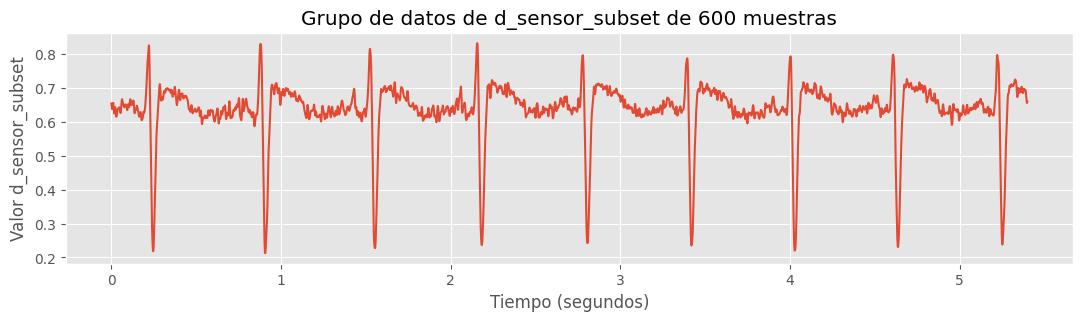

In [32]:

# Graficar los valores de d_sensor_subset correspondientes al primer segundo
plt.figure(figsize=(13, 3))
plt.plot(df_2)
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor_subset de 600 muestras")  # Cambiar el título
plt.show()


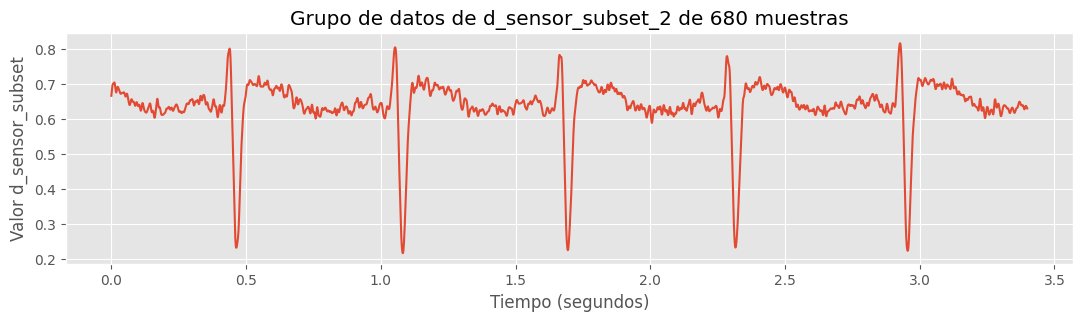

In [33]:

# Graficar los valores de d_sensor_subset correspondientes al primer segundo
plt.figure(figsize=(13, 3))
plt.plot(df_3)
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Valor d_sensor_subset")  # Cambiar el nombre del eje y
plt.title("Grupo de datos de d_sensor_subset_2 de 680 muestras")  # Cambiar el título
plt.show()


In [34]:
len(df_2)/600

9.0

In [35]:
len(df_3)/680

5.0

In [36]:
d_obs_2 = df["senal_filtro2_corr"].values[5128:10528].reshape(9, 600)
d_obs_2

array([[0.65380706, 0.65137808, 0.64695721, ..., 0.63326217, 0.63164443,
        0.62824469],
       [0.62359407, 0.61859796, 0.6140753 , ..., 0.64464005, 0.63794043,
        0.63052714],
       [0.6240195 , 0.61975075, 0.61845379, ..., 0.64732935, 0.6465228 ,
        0.64544529],
       ...,
       [0.66530008, 0.66804786, 0.67133753, ..., 0.67419641, 0.67523509,
        0.67669789],
       [0.67831849, 0.67962573, 0.68005728, ..., 0.70323275, 0.7012188 ,
        0.69868171],
       [0.69550501, 0.69149908, 0.68648076, ..., 0.65556249, 0.6558671 ,
        0.65910769]])

In [37]:
d_obs_3 = df["senal_filtro2_corr"].values[10528:13928].reshape(5, 680)
d_obs_3


array([[0.664959  , 0.67257281, 0.68071752, ..., 0.62932293, 0.62934135,
        0.63087279],
       [0.63322423, 0.63602113, 0.63929507, ..., 0.61986126, 0.61480747,
        0.61061227],
       [0.60811138, 0.60767298, 0.60920167, ..., 0.6345809 , 0.63253483,
        0.62833499],
       [0.62293516, 0.61755859, 0.6133693 , ..., 0.62482449, 0.62268441,
        0.62065758],
       [0.61885267, 0.61724176, 0.61569106, ..., 0.63197295, 0.63020786,
        0.62895471]])

<Figure size 1300x200 with 0 Axes>

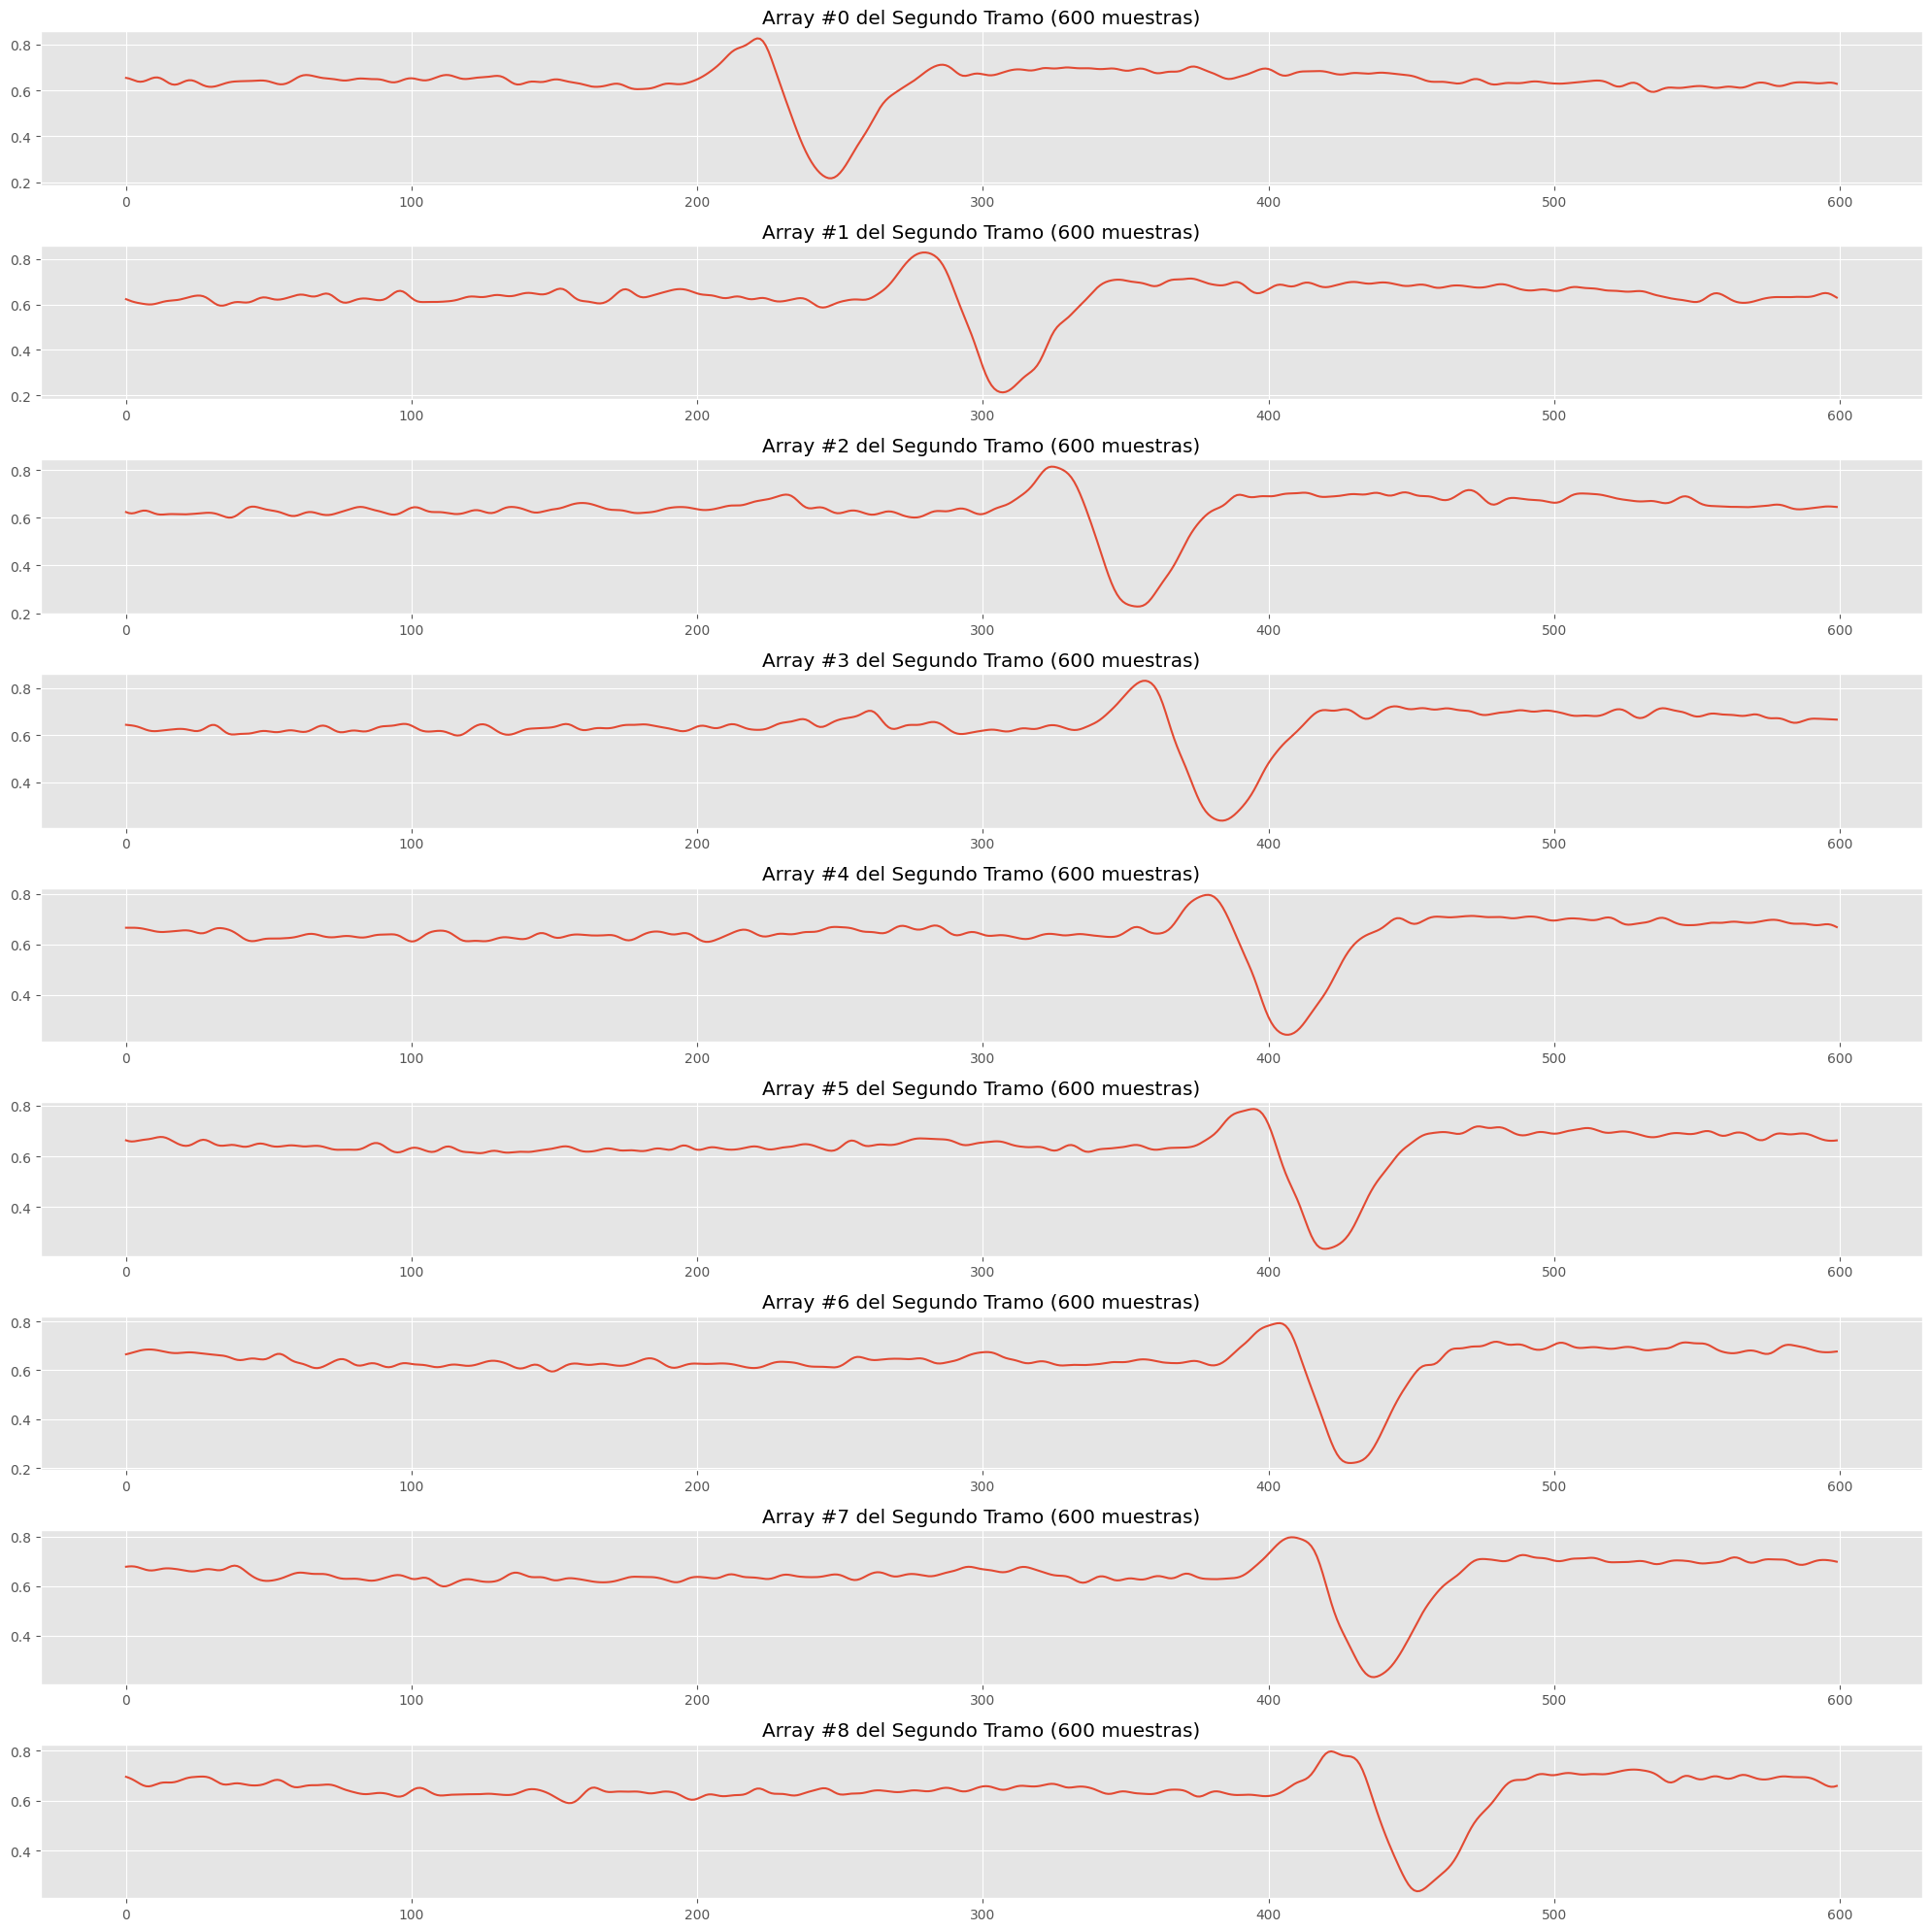

(9, 600)

In [38]:
plt.figure(figsize=(13,2))
#plt.plot(d_obs_2[8])


fig, axs = plt.subplots(nrows=9, figsize=(20, 20))

for i in range(9):
    axs[i].plot(d_obs_2[i])
    axs[i].set_title(f"Array #{i} del Segundo Tramo (600 muestras)")
    
plt.tight_layout()
plt.show()

d_obs_2.shape

<Figure size 1300x200 with 0 Axes>

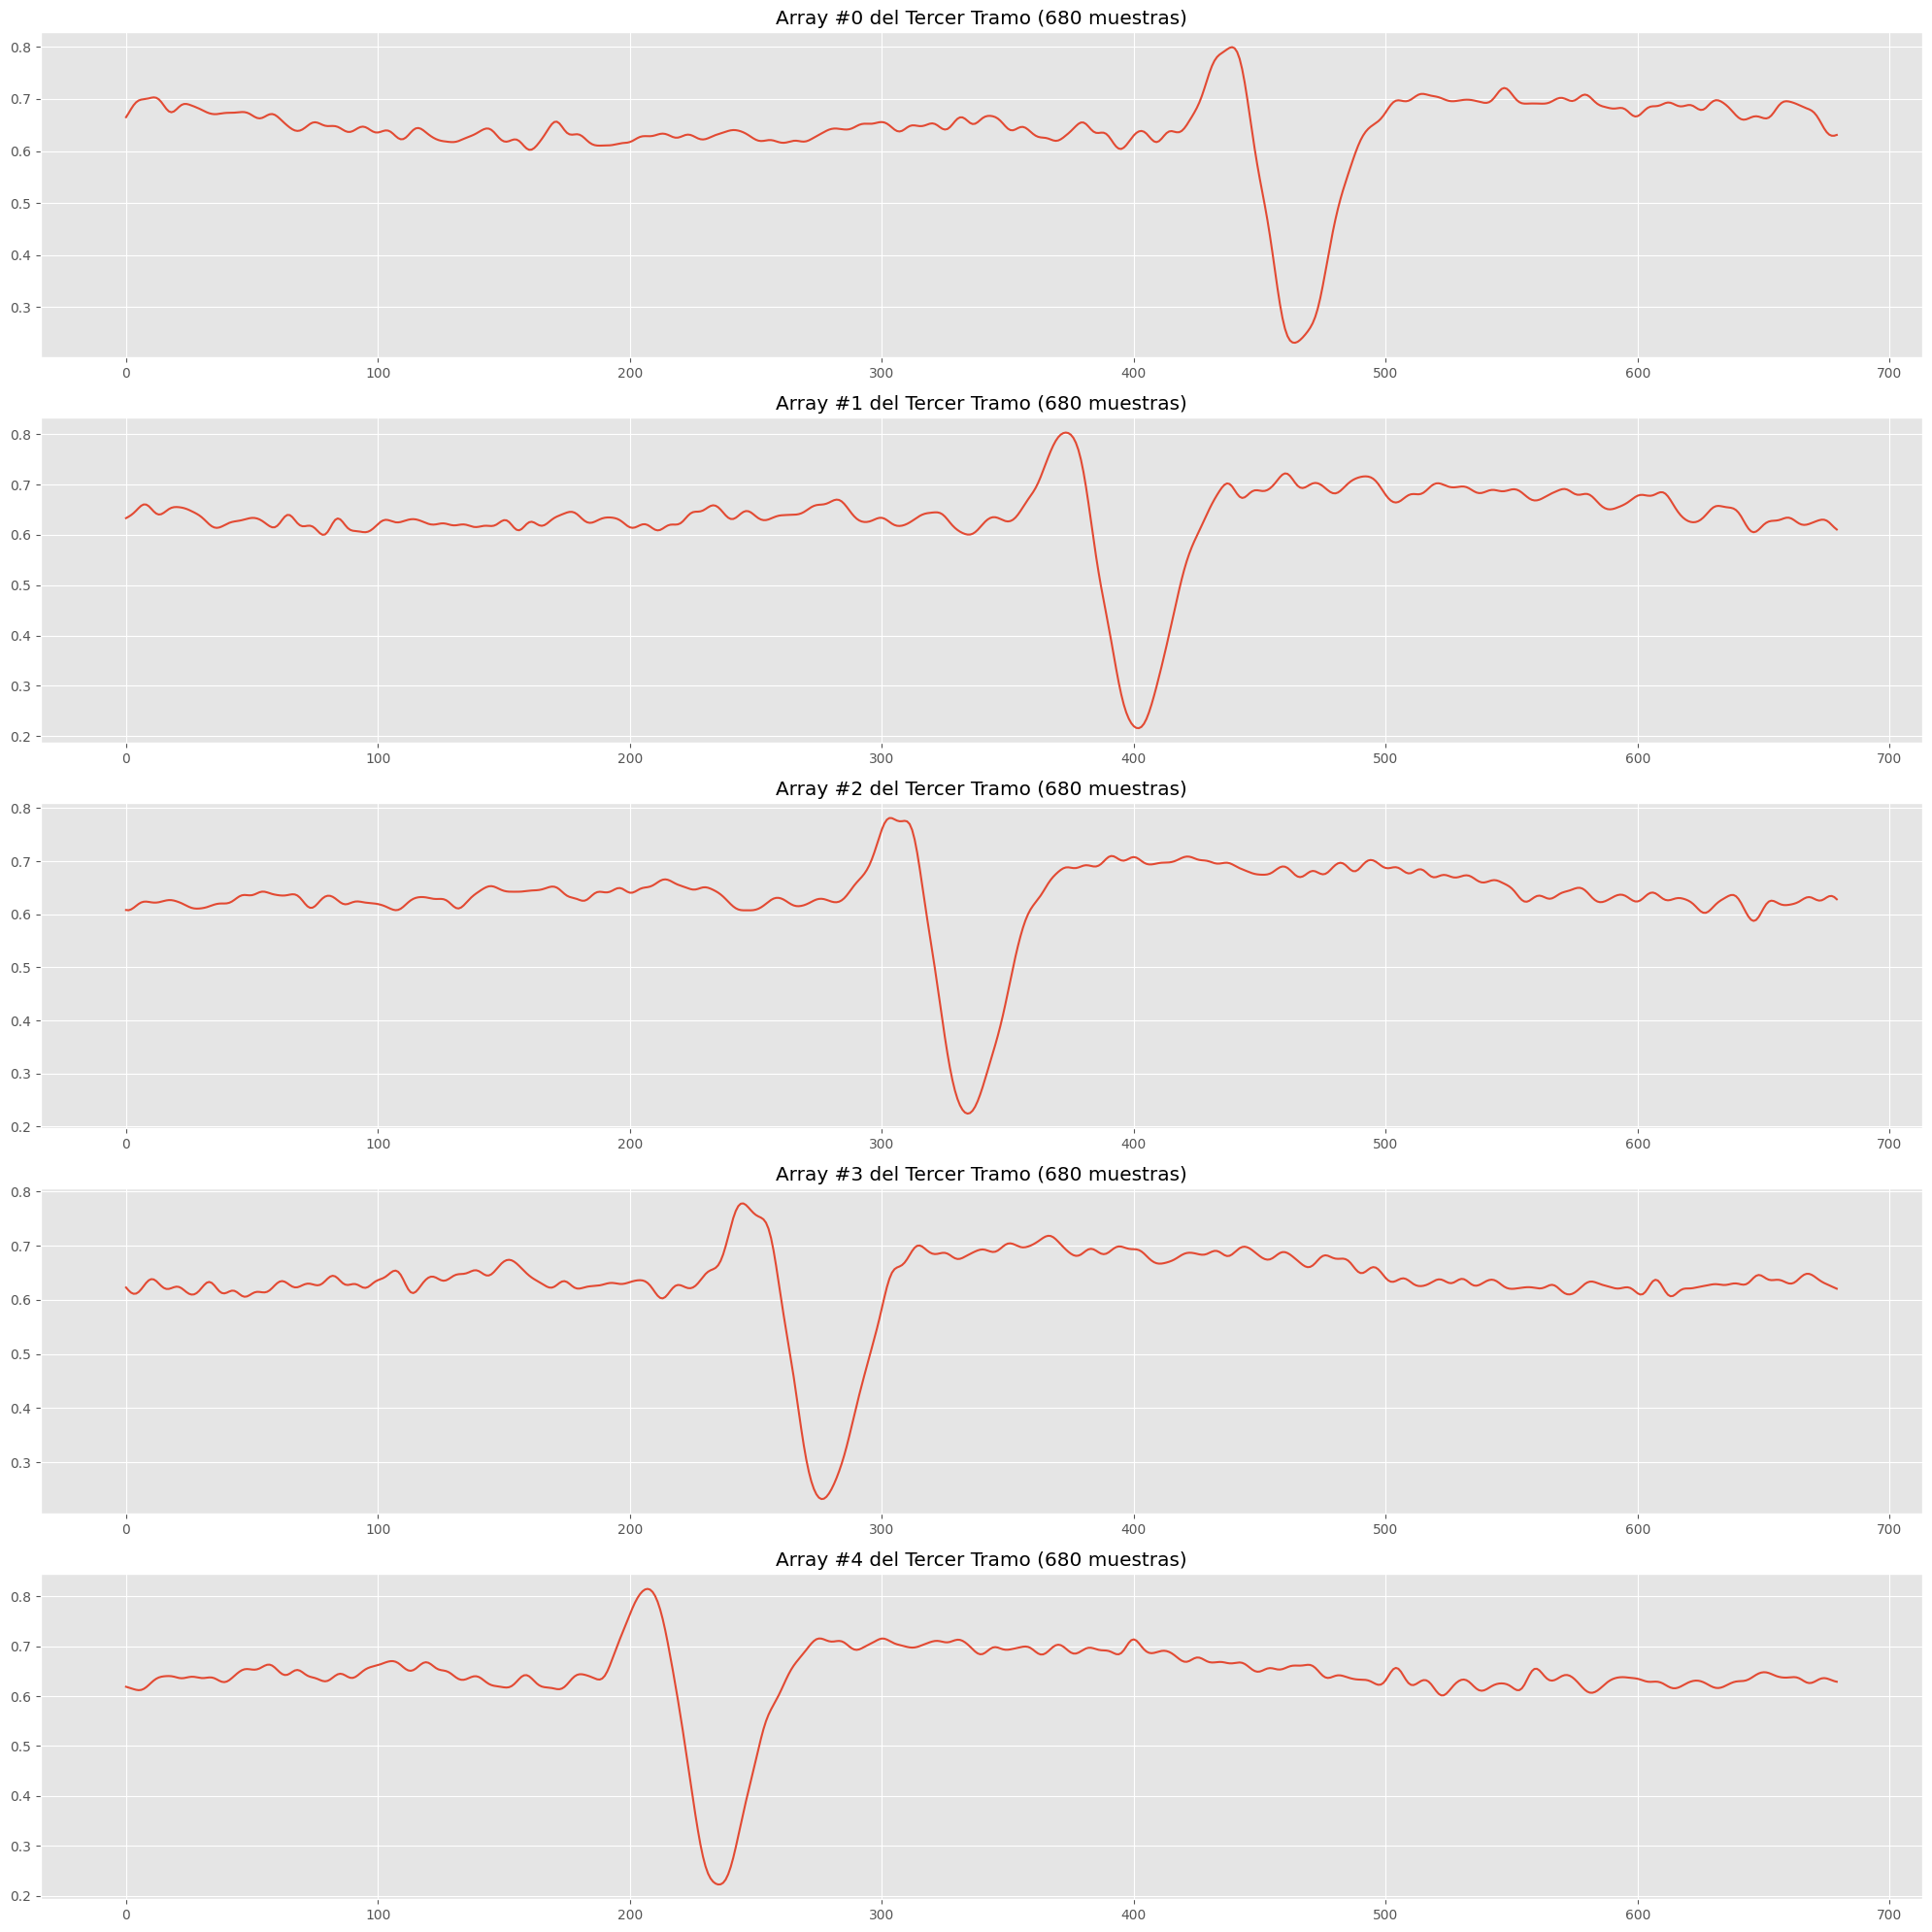

(5, 680)

In [39]:
plt.figure(figsize=(13,2))
#plt.plot(d_obs_3[4])

fig, axs = plt.subplots(nrows=5, figsize=(20, 20))

for i in range(5):
    axs[i].plot(d_obs_3[i])
    axs[i].set_title(f"Array #{i} del Tercer Tramo (680 muestras)")
    
plt.tight_layout()
plt.show()

d_obs_3.shape

In [40]:
# Tamaño requerido para los subarrays
tamano_subarray = 680

# Agregar ceros al final de los subarrays en array1 y array2
d_obs = np.concatenate((d_obs, np.zeros((8, tamano_subarray - d_obs.shape[1]))), axis=1)
d_obs_2 = np.concatenate((d_obs_2, np.zeros((9, tamano_subarray - d_obs_2.shape[1]))), axis=1)

# Concatenar los arrays en uno solo
array_ecgbasal = np.concatenate((d_obs, d_obs_2, d_obs_3), axis=0)
array_ecgbasal

array([[0.68469672, 0.65965255, 0.64030364, ..., 0.        , 0.        ,
        0.        ],
       [0.70239868, 0.70482148, 0.70841502, ..., 0.        , 0.        ,
        0.        ],
       [0.69385707, 0.689261  , 0.68193726, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.60811138, 0.60767298, 0.60920167, ..., 0.6345809 , 0.63253483,
        0.62833499],
       [0.62293516, 0.61755859, 0.6133693 , ..., 0.62482449, 0.62268441,
        0.62065758],
       [0.61885267, 0.61724176, 0.61569106, ..., 0.63197295, 0.63020786,
        0.62895471]])

In [41]:
np.save('array_ecgbasal.npy', array_ecgbasal)
len(array_ecgbasal)
len(d_obs[1])

680

## Descripción de categoria de los ejercicios realizado en la clase de ECG

| Descripción | Categoria |
|----------|----------|
| Basal    | 0   |
| Respiracion   | 1   | 
| Post-Ejercicio    | 2   |


In [42]:
#array4 = np.concatenate((array3,  np.repeat(0, array3.shape[0]).reshape(-1,1)), axis=1)

# Creamos una categoría
target_0 = np.repeat(0, array_ecgbasal.shape[0])
target_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
ecg_basal = {"base": array_ecgbasal, "target": target_0}
ecg_basal

{'base': array([[0.68469672, 0.65965255, 0.64030364, ..., 0.        , 0.        ,
         0.        ],
        [0.70239868, 0.70482148, 0.70841502, ..., 0.        , 0.        ,
         0.        ],
        [0.69385707, 0.689261  , 0.68193726, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.60811138, 0.60767298, 0.60920167, ..., 0.6345809 , 0.63253483,
         0.62833499],
        [0.62293516, 0.61755859, 0.6133693 , ..., 0.62482449, 0.62268441,
         0.62065758],
        [0.61885267, 0.61724176, 0.61569106, ..., 0.63197295, 0.63020786,
         0.62895471]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}